<a href="https://colab.research.google.com/github/achelmasoudi/TrueMood_EmotionRecognition_ModelTraining/blob/main/TrueMood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/msambare/fer2013")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: achelm9
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset


100%|██████████| 4.20G/4.20G [00:34<00:00, 129MB/s]


In [ ]:
import pandas as pd  # Veri manipülasyonu ve analizi için
import numpy as np  # Sayısal işlemler ve dizilerle çalışma için
import cv2 as cv  # Görüntü işleme görevleri için
import os  # Dosya yolları gibi işletim sistemi ile etkileşim için
import tensorflow as tf  # Sinir ağı modelleri oluşturmak ve eğitmek için

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Gerçek zamanlı veri artırma için
from tensorflow.keras.models import load_model  # Kaydedilmiş bir Keras modelini yüklemek için
from keras.models import Sequential  # Katmanları sıralı bir modelde oluşturmak için
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten  # Model katmanları oluşturmak için
from keras.optimizers import Adam  # Optimizasyon algoritmaları için
from keras.layers import BatchNormalization  # Sinir ağı katmanlarında Batch Normalization uygulamak için
from keras.regularizers import l2  # Aşırı öğrenmeyi önlemek için L2 düzenleme
from keras.callbacks import ReduceLROnPlateau, EarlyStopping  # Özel callback fonksiyonları için

import warnings  # Uyarıları ele almak için
import sys  # Python yorumlayıcısı ile etkileşim için

# Gereksiz uyarı mesajlarını görmezden gel
if not sys.warnoptions:
    warnings.simplefilter("ignore")  # Basit uyarıları devre dışı bırak
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Deprecation uyarılarını görmezden gel

In [ ]:
import shutil

# Orijinal veri seti yolu ve eğitim/test veri seti dizinlerini tanımla
original_dataset_dir = '/content/fer2013/train'
train_dir = 'fer2013_train'
test_dir = 'fer2013_test'

# Eğitim ve test veri seti dizinlerini oluştur
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Eğitim veri seti oranını belirle
train_ratio = 0.8

# Her duygu kategorisi için döngü başlat
for emotion in os.listdir(original_dataset_dir):
    emotion_dir = os.path.join(original_dataset_dir, emotion)
    if os.path.isdir(emotion_dir):
        # Kategoriye ait görüntü dosyalarının listesini al
        images = [f for f in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, f))]

        # Görüntü dosyalarını rastgele sırala
        np.random.shuffle(images)

        # Görüntüleri eğitim ve test olarak böl
        train_size = int(len(images) * train_ratio)
        train_images = images[:train_size]
        test_images = images[train_size:]

        # Eğitim ve test için kategorilere ait dizinleri oluştur
        train_emotion_dir = os.path.join(train_dir, emotion)
        test_emotion_dir = os.path.join(test_dir, emotion)
        os.makedirs(train_emotion_dir, exist_ok=True)
        os.makedirs(test_emotion_dir, exist_ok=True)

        # Görüntüleri ilgili dizinlere kopyala
        for image in train_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(train_emotion_dir, image))
        for image in test_images:
            shutil.copy(os.path.join(emotion_dir, image), os.path.join(test_emotion_dir, image))

print("Veri seti bölme işlemi tamamlandı")

Veri seti bölme işlemi tamamlandı


In [ ]:
import cv2

# Görüntüyü yükle
img = cv2.imread('/content/fer2013/train/happy/Training_10070997.jpg')
# Görüntünün boyutlarını al
height, width, channels = img.shape
print(f'Boyutlar: {width}x{height}')

Boyutlar: 48x48


In [ ]:
# Eğitim veri seti için veri artırma işlemleri
train_data_generator = ImageDataGenerator(
    rescale=1./255,  # Piksel değerlerini normalize et
    rotation_range=15,  # Rastgele 15 derece döndürme
    width_shift_range=0.15,  # Yatayda %15 kaydırma
    height_shift_range=0.15,  # Dikeyde %15 kaydırma
    shear_range=0.15,  # Kesme dönüşümleri
    zoom_range=0.15,  # Yakınlaştırma oranı
    horizontal_flip=True  # Rastgele yatay çevirme
)

# Eğitim veri setini yükle
fer_training_data = train_data_generator.flow_from_directory(
    '/content/fer2013_train',  # Eğitim veri seti yolu
    target_size=(48, 48),  # Görüntüleri 48x48 boyutlarına getir
    batch_size=64,  # Her partide 64 görüntü
    color_mode='grayscale',  # Görüntüleri gri tonlamada yükle
    class_mode='categorical'  # Etiketler kategorik formatta olacak
)


fer_training_data

Found 27558 images belonging to 7 classes.


In [ ]:
# Test veri seti için veri artırma işlemi (sadece normalizasyon)
# Rescales images by dividing pixel values by 255 (normalization)
test_data_generator = ImageDataGenerator(rescale=1./255)

# Test veri setini yükle
fer_test_data = test_data_generator.flow_from_directory(
    '/content/fer2013_test',  # Test veri seti yolu
    target_size=(48, 48),  # Görüntüleri 48x48 boyutlarına getir
    batch_size=64,  # Her partide 64 görüntü
    color_mode='grayscale',  # Görüntüleri gri tonlamada yükle
    class_mode='categorical'  # Etiketler kategorik formatta olacak
)

# fer_test_data is now a generator that yields batches of test images and their labels
fer_test_data

Found 10337 images belonging to 7 classes.


In [ ]:
# TensorFlow'un Keras kütüphanesinden optimizasyon modülünü içe aktar
from tensorflow.keras import optimizers

# Farklı optimizasyon algoritmalarını belirli ayarlarla tanımlayan bir liste oluştur
optims = [
    # Nadam optimizasyon algoritması (Adam + Nesterov hızlandırması)
    optimizers.Nadam(
        learning_rate=0.001,  # Öğrenme oranı (modelin ne kadar hızlı öğreneceğini belirler)
        beta_1=0.9,  # İlk moment tahmini için momentum parametresi
        beta_2=0.999,  # İkinci moment tahmini için momentum parametresi
        epsilon=1e-07,  # Sayısal kararlılığı artırmak için küçük sabit bir değer
        name='Nadam'  # Optimizatörün adı
    ),
    # Adam optimizasyon algoritması (momentum ve adaptif öğrenme oranı kullanan bir optimizatör)
    optimizers.Adam(
        learning_rate=0.001  # Öğrenme oranı
    ),
]

In [ ]:
# Keras'tan Sequential modeli ve katmanlar içe aktarılıyor
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Ardışık bir model oluşturuluyor
model = Sequential()

# İlk Conv2D katmanı: 512 filtre, 5x5 çekirdek boyutu, ELU aktivasyonu
model.add(
        Conv2D(
            filters=512,
            kernel_size=(5,5),
            input_shape=(48, 48, 1),  # Giriş boyutu (48x48, tek kanallı görüntü)
            activation='elu',
            padding='same',  # Kenar doldurma
            kernel_initializer='he_normal',  # Ağırlıkların He normalizasyonu ile başlatılması
            name='conv2d_1'
        )
    )
model.add(BatchNormalization(name='batchnorm_1'))  # Batch Normalization ile ağırlıklar normalize edilir

# İkinci Conv2D katmanı: 256 filtre, 5x5 çekirdek boyutu
model.add(
        Conv2D(
            filters=256,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
model.add(BatchNormalization(name='batchnorm_2'))  # Normalizasyon

# Maksimum havuzlama ve Dropout uygulanıyor
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.25, name='dropout_1'))  # Overfitting'i önlemek için %25 Dropout

# Daha küçük filtrelerle (3x3) Conv2D katmanları
model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
model.add(BatchNormalization(name='batchnorm_3'))
model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
model.add(BatchNormalization(name='batchnorm_4'))

# Havuzlama ve Dropout tekrar uygulanıyor
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.25, name='dropout_2'))

# Daha fazla Conv2D katmanı, 256 ve 512 filtreler
model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
model.add(BatchNormalization(name='batchnorm_5'))
model.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
model.add(BatchNormalization(name='batchnorm_6'))

# Son havuzlama ve Dropout
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.25, name='dropout_3'))

# Model düzleştirilip tam bağlantılı katmanlara geçirilir
model.add(Flatten(name='flatten'))

# Yoğun katman: 256 nöron, ELU aktivasyonu
model.add(
        Dense(
            256,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
model.add(BatchNormalization(name='batchnorm_7'))
model.add(Dropout(0.25, name='dropout_4'))

# Çıkış katmanı: 7 sınıf için softmax aktivasyonu
model.add(
        Dense(
            7,
            activation='softmax',  # Çok sınıflı sınıflandırma için softmax
            name='out_layer'
        )
    )

# Model derleniyor: Kayıp fonksiyonu, optimizasyon ve metrikler belirtiliyor
model.compile(
        loss='categorical_crossentropy',  # Çok sınıflı sınıflandırma için uygun kayıp fonksiyonu
        optimizer='adam',  # Adam optimizatörü
        metrics=['accuracy']  # Doğruluk metriği
    )

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 512)         │          13,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 48, 48, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 256)         │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_2 (BatchNormalization)     │ (None, 48, 48, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_1 (MaxPooling2D)           │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_3 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_4 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_2 (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_5 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_6 (BatchNormalization)     │ (None, 12, 12, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_3 (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_7 (BatchNormalization)     │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,937,159 (37.91 MB)

 Trainable params: 9,933,063 (37.89 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [ ]:
# Model eğitimi sırasında erken durdurma (EarlyStopping) mekanizması tanımlanıyor.
early_stopping = EarlyStopping(
    monitor='val_accuracy',           # İzlenecek metrik: doğrulama doğruluğu (val_accuracy)
    min_delta=0.00005,                # İyileşme miktarı, bu değerin altındaki değişimler göz ardı edilir
    patience=11,                      # Modelin iyileşme göstermediği dönem sayısı (epoch) beklenir
    verbose=1,                        # Konsola bilgi yazdırma seviyesi
    restore_best_weights=True,        # En iyi ağırlıklar, eğitim sonunda otomatik olarak yüklenir
)

# Öğrenme oranını (learning rate) dinamik olarak azaltmak için bir mekanizma tanımlanıyor.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',           # İzlenecek metrik: doğrulama doğruluğu (val_accuracy)
    factor=0.5,                       # Öğrenme oranı bu faktörle çarpılarak azaltılır
    patience=7,                       # Öğrenme oranı ancak belirtilen epoch sayısı boyunca iyileşme olmazsa azaltılır
    min_lr=1e-7,                      # Öğrenme oranının ulaşabileceği en düşük değer
    verbose=1,                        # Konsola bilgi yazdırma seviyesi
)

# Callback fonksiyonları bir listeye ekleniyor
callbacks = [
    early_stopping,                   # Erken durdurma mekanizması
    lr_scheduler,                     # Öğrenme oranı azaltma mekanizması
]

In [ ]:
# Eğitim için batch boyutu belirleniyor
batch_size = 64

# Modelin eğitim süreci başlatılıyor
history = model.fit(
    fer_training_data,             # Eğitim verileri (Feature ve Label çiftleri)
    epochs=70,                     # Toplam eğitim döngüsü (epoch) sayısı
    validation_data=fer_test_data, # Doğrulama verileri, modelin doğruluğu bu veri üzerinde kontrol edilir
    batch_size=64,                 # Her bir batch'teki veri miktarı
    callbacks=callbacks,           # Eğitim sırasında uygulanacak callback fonksiyonları (ör. EarlyStopping, ReduceLROnPlateau)
)

Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


431/431 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.2243 - loss: 2.1225 - val_accuracy: 0.3320 - val_loss: 1.7013 - learning_rate: 0.0010
Epoch 2/70
431/431 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.3161 - loss: 1.7281 - val_accuracy: 0.3996 - val_loss: 1.5529 - learning_rate: 0.0010
Epoch 3/70
431/431 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.4224 - loss: 1.4893 - val_accuracy: 0.4993 - val_loss: 1.2826 - learning_rate: 0.0010
Epoch 4/70
431/431 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.4910 - loss: 1.3386 - val_accuracy: 0.5184 - val_loss: 1.2473 - learning_rate: 0.0010
Epoch 5/70
431/431 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.5353 - loss: 1.2342 - val_accuracy: 0.5789 - val_loss: 1.1147 - learning_rate: 0.0010
Epoch 6/70
431/431 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.5448 - loss: 1.1899 - val_accuracy: 0.5982 - val_loss: 1.0645 - learning_rate: 0.0010
Epoch 7/70
431/431 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.5613 - loss: 1.1394

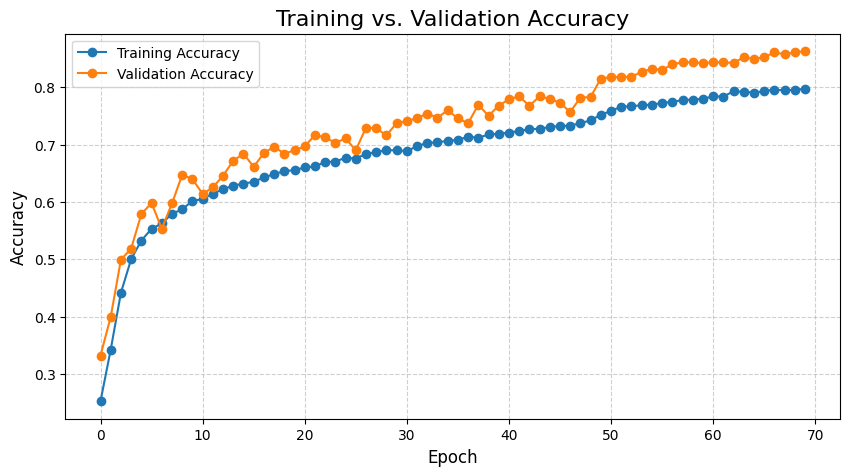

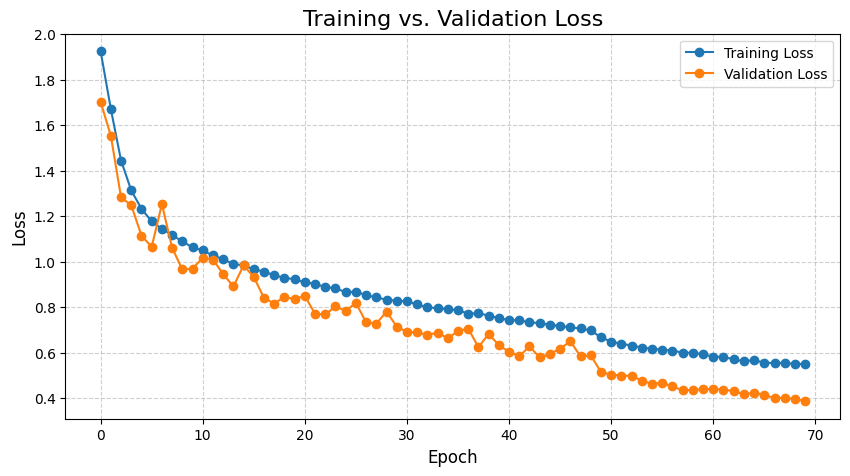

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğu grafiği
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs. Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Eğitim ve doğrulama kaybı grafiği
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs. Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Validation veri kümesinde modeli değerlendiriyoruz
loss, accuracy = model.evaluate(fer_test_data, verbose=1)

print(f'Doğrulama Kaybı: {loss}')
print(f'Doğrulama Doğruluğu: {accuracy * 100:.2f}%')

162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8656 - loss: 0.3753
Doğrulama Kaybı: 0.386823832988739
Doğrulama Doğruluğu: 86.29%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Test etmek istediğiniz resmin yolu
image_path = '/content/Angry Face.jpg'

# Resmi yükle ve modelin beklediği formatta yeniden boyutlandır
img = image.load_img(image_path, target_size=(48, 48), color_mode="grayscale")

# Resmi numpy array'e dönüştür
img_array = image.img_to_array(img)

# Verisetinin normalizasyonu (0-255 arasındaki piksel değerlerini 0-1 arasına çekeriz)
img_array = img_array / 255.0

# Modelin beklediği formatta 4 boyutlu bir array haline getirme
img_array = np.expand_dims(img_array, axis=0)  # Bu, (1, 48, 48, 1) boyutunu verir

# Modeli kullanarak tahmin yapma
pred = model.predict(img_array)

# Tahmin edilen sınıfı al (en yüksek olasılığa sahip sınıf)
predicted_class = np.argmax(pred, axis=1)

# Sınıf isimlerini almak
labels = list(fer_test_data.class_indices.keys())

# Tahmin edilen duygu
predicted_emotion = labels[predicted_class[0]]

# Sonuçları yazdırma
print(f"Tahmin Edilen Duygu: {predicted_emotion}")

# Resmi görselleştirme
plt.imshow(img, cmap='gray')
plt.title(f'Tahmin: {predicted_emotion}')
plt.axis('off')  # Eksenleri gizleme
plt.show()

In [ ]:
# Tahminleri al ve confusion matrix'i oluştur
y_pred = model.predict(fer_test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = fer_test_data.classes

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the trained model
model.save('emotion_model.h5')

In [ ]:
# TensorFlow Lite Converter kullanarak dönüştürme
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("emotion_mod.tflite", "wb").write(tflite_model)

Saved artifact at '/tmp/tmpc_pd04b8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  132030709707728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132030709587936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132030700839056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132030700838704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132030700833072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132030700839584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132030700845392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132030700844512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132030701048704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132030701049232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132030701046768:

39739768